# Recognicition of The Office Quotes

For the NLP project we decided to get a Dataset consisting of 2 csv files:
- parent.csv :

    These are all quotes when the character was replying to someone else from the show.

- talking_head.csv :

    These are all quotes, from when the characters were directly interacting with the camera.

All the Quotes are from 4 main characters of the show, meaning they are the ones with the more prominent speaking roles:
- Michael
- Pam
- Jim
- Dwight

## Description of Dataset

Before we start with the Preprocessing steps and working with the Data in an NLP sense. We will take a look into the Data and see what exactly it offers and how balanced it is.

For that we create a DF for each kind of quote:
- camera quote
- reply

and merge them later to have both reply and camera quote in one df for a better comparison of what we are dealing with.

In [104]:
## --------------- IMPORTS ------------------- ##
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import tensorflow as tf

In [105]:
df_reply = pd.read_csv('quotes/parent_reply.csv')
df_monologue = pd.read_csv('quotes/talking_head.csv')

In [106]:
df_reply.shape

(26150, 4)

In total here we have 26150 quotes

In [107]:
df_reply.describe()

,parent_id
count,26150.000000
mean,13074.500000
std,7548.999106
min,0.000000
25%,6537.250000
50%,13074.500000
75%,19611.750000
max,26149.000000


In [108]:
df_reply.head()

,parent_id,parent,reply,character
0,0,"Oh, I told you. I couldn’t close it. So…",So you’ve come to the master for guidance? Is ...,Michael
1,1,"Actually, you called me in here, but yeah.","All right. Well, let me show you how it’s done.",Michael
2,2,Well. I don’t know.,"If you think she’s cute now, you should have s...",Michael
3,3,What?,Any messages?,Michael
4,4,"Uh, yeah. Just a fax.","Oh! Pam, this is from Corporate. How many time...",Michael


<AxesSubplot:>

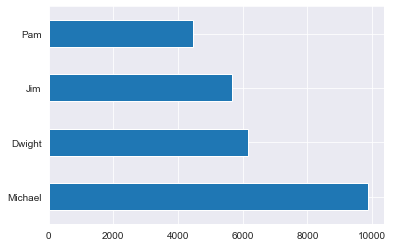

In [109]:
# now lets get the counts of the characters appearances in here
char_count = df_reply['character'].value_counts()
# next we want t0 visualize that in a barchart to get an overview of representation and balance
char_count.plot(kind="barh")

<AxesSubplot:ylabel='character'>

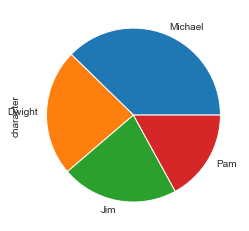

In [110]:
char_count.plot(kind="pie")

In [111]:
char_count

Michael    9859
Dwight     6163
Jim        5678
Pam        4450
Name: character, dtype: int64

Here we can see that here is a clear imbalance when it comes to characters replies.
Michael has the most with 9859 quotes saved in this set, nearly as much as the quotes of jim and pam combined. Therefore Jim and Pam have the least representation in this set.

The reason behind this though, is that Michael is the main character and his speaking role and time on camera is much higher compared to Jim and Pam.

### Monologue Dataset

In [112]:
df_monologue.shape

(1749, 3)

Here we can see we have crucially less quotes in this set. In total 1749 datapoints.

In [113]:
df_monologue.describe()

,quote_id
count,1749.000000
mean,874.000000
std,505.037127
min,0.000000
25%,437.000000
50%,874.000000
75%,1311.000000
max,1748.000000


In [114]:
df_monologue.head()

,quote_id,quote,character
0,0,"Yes, I’d like to speak to your office manager,...",Michael
1,1,"People say I am the best boss. They go, “God w...",Michael
2,2,Corporate really doesn’t really interfere with...,Michael
3,3,"Am I going to tell them? No, I am not going to...",Michael
4,4,I think I’m a role model here. I think I garne...,Michael


<AxesSubplot:>

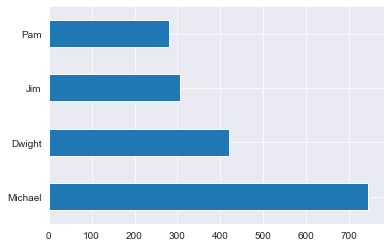

In [115]:
char_count = df_monologue['character'].value_counts()
# next we want t visualize that in a barchart to get an overview of representation and balance
char_count.plot(kind="barh")

<AxesSubplot:ylabel='character'>

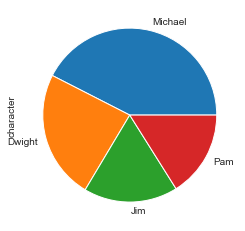

In [116]:
char_count.plot(kind="pie")

In [117]:
char_count

Michael    743
Dwight     419
Jim        306
Pam        281
Name: character, dtype: int64

Repeatedly we can see that here once again an imbalance is present between michael and the other three characters.

### Merged Data

Now lets merge the two dataframes and see how well each character is represented. We can then also use this dataset for preprocessing and training the model.

In [118]:
df_for_merge_reply = df_reply[['reply', 'character']]
df_for_merge_monologue = df_monologue[['quote', 'character']]
# to make the merge possible we have to rename the column names of the ro merge monologue dataframe
df_for_merge_reply.columns = ['quote','character']
df_merged = pd.concat([df_for_merge_reply, df_for_merge_monologue], ignore_index = True)

In [119]:
df_merged.shape

(27899, 2)

In [120]:
df_merged.head()

,quote,character
0,So you’ve come to the master for guidance? Is ...,Michael
1,"All right. Well, let me show you how it’s done.",Michael
2,"If you think she’s cute now, you should have s...",Michael
3,Any messages?,Michael
4,"Oh! Pam, this is from Corporate. How many time...",Michael


<AxesSubplot:>

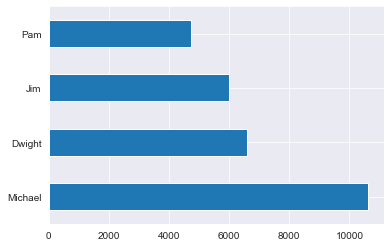

In [121]:
char_count = df_merged['character'].value_counts()
char_count.plot(kind="barh")

<AxesSubplot:ylabel='character'>

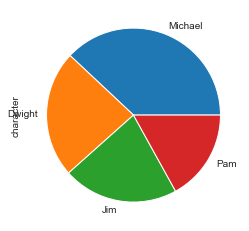

In [122]:
char_count.plot(kind="pie")

<AxesSubplot:>

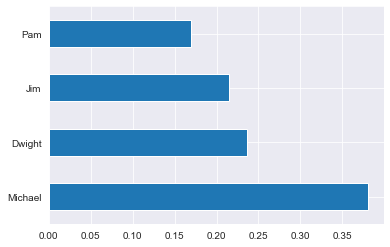

In [123]:
df_merged['character'].value_counts(normalize=True).plot(kind="barh")

In [124]:
char_count

Michael    10602
Dwight      6582
Jim         5984
Pam         4731
Name: character, dtype: int64

### Conclusion

In both Sets there is an imbalance between the more and less prominent speaking characters in the show, making Michael the one with the most quotes and therefore the best represented.

- Michael has a total of 10602 quotes in the entire dataset
- Dwight has a total of 6582 quotes
- Jim has a total of 5984 quotes
- Pam has a total of 4731 quotes

## Preprocessing

Before we can work with the quotes and use it for training we need to preprocess each of them.

Typical preprocessing steps are:
1. Tokenization
2. Lower casing
3. Stop Word Removal
4. Stemming
5. Lemmatization

And these are also the steps we will go through with our dataset. To make it easier we will be using the merged dataframe.

Why do we need preprocessing?
- We want to change the raw data into a clean data set. It reduces noisy data and other inconcistencies which would be really inconvenient to have in a dataset when training a model.

In [125]:
# lower case the column quotes
df_merged['lower'] = df_merged['quote'].str.lower()
df_merged.head()

,quote,character,lower
0,So you’ve come to the master for guidance? Is ...,Michael,so you’ve come to the master for guidance? is ...
1,"All right. Well, let me show you how it’s done.",Michael,"all right. well, let me show you how it’s done."
2,"If you think she’s cute now, you should have s...",Michael,"if you think she’s cute now, you should have s..."
3,Any messages?,Michael,any messages?
4,"Oh! Pam, this is from Corporate. How many time...",Michael,"oh! pam, this is from corporate. how many time..."


In [126]:
def tokenize(column):
    tokens = word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [127]:
# we will not change the quote column we will be adding a new table to the merged dataframe
df_merged['tokenized'] = df_merged.apply(lambda x: tokenize(x['lower']), axis = 1)
df_merged.head()

,quote,character,lower,tokenized
0,So you’ve come to the master for guidance? Is ...,Michael,so you’ve come to the master for guidance? is ...,"[so, you, ve, come, to, the, master, for, guid..."
1,"All right. Well, let me show you how it’s done.",Michael,"all right. well, let me show you how it’s done.","[all, right, well, let, me, show, you, how, it..."
2,"If you think she’s cute now, you should have s...",Michael,"if you think she’s cute now, you should have s...","[if, you, think, she, s, cute, now, you, shoul..."
3,Any messages?,Michael,any messages?,"[any, messages]"
4,"Oh! Pam, this is from Corporate. How many time...",Michael,"oh! pam, this is from corporate. how many time...","[oh, pam, this, is, from, corporate, how, many..."


In [128]:
df_merged.drop('lower', inplace=True, axis=1)

In [129]:
# next is the stopword removal
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
def remove_stopwords(column):
    stopw = set(stopwords.words("english"))
    return [word for word in column if not word in stopw]

In [131]:
df_merged['sw_removed'] = df_merged.apply(lambda x: remove_stopwords(x['tokenized']), axis = 1)

# drop the tokenized column
df_merged.drop('tokenized', inplace=True, axis=1)
df_merged.head()

,quote,character,sw_removed
0,So you’ve come to the master for guidance? Is ...,Michael,"[come, master, guidance, saying, grasshopper]"
1,"All right. Well, let me show you how it’s done.",Michael,"[right, well, let, show, done]"
2,"If you think she’s cute now, you should have s...",Michael,"[think, cute, seen, couple, years, ago]"
3,Any messages?,Michael,[messages]
4,"Oh! Pam, this is from Corporate. How many time...",Michael,"[oh, pam, corporate, many, times, told, specia..."


In [132]:
def stemming(column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in column]

In [133]:
df_merged["stemmed"] = df_merged.apply(lambda x: stemming(x['sw_removed']), axis=1)
# drop the sw_removed column
df_merged.drop('sw_removed', inplace=True, axis=1)

#copy stemmed words for LDA
df_for_lda = df_merged.copy()

df_merged.head()

,quote,character,stemmed
0,So you’ve come to the master for guidance? Is ...,Michael,"[come, master, guidanc, say, grasshopp]"
1,"All right. Well, let me show you how it’s done.",Michael,"[right, well, let, show, done]"
2,"If you think she’s cute now, you should have s...",Michael,"[think, cute, seen, coupl, year, ago]"
3,Any messages?,Michael,[messag]
4,"Oh! Pam, this is from Corporate. How many time...",Michael,"[oh, pam, corpor, mani, time, told, special, f..."


In [134]:
def rejoin(column):
    return ( " ".join(column))

In [135]:
df_merged['preprocessed'] = df_merged.apply(lambda x: rejoin(x['stemmed']), axis=1)

df_merged.drop('stemmed', inplace=True, axis=1)
df_merged.head()

,quote,character,preprocessed
0,So you’ve come to the master for guidance? Is ...,Michael,come master guidanc say grasshopp
1,"All right. Well, let me show you how it’s done.",Michael,right well let show done
2,"If you think she’s cute now, you should have s...",Michael,think cute seen coupl year ago
3,Any messages?,Michael,messag
4,"Oh! Pam, this is from Corporate. How many time...",Michael,oh pam corpor mani time told special file cabi...


## Vectorization

Since machine learning models need numerical data, vectorization is performed. This process converts text data into well-defined numerical data / vectors. Commonly used methods for this conversion are Bag-of-Words and Word Embedding.

### Train-Test-Split

In [136]:
# train test split
X, y = df_merged['preprocessed'], df_merged['character']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(X_train.shape)
print(X_test.shape)

(22319,)
(5580,)


### Tf-Idf
advanced variant of the Bag-of-Words that uses the term frequency–inverse document frequency


In [137]:
# Tfidf
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### CountVectorizer
Convert a collection of text documents to a matrix of token counts.

In [138]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

X_train_cv = count_vectorizer.transform(X_train)
X_test_cv  = count_vectorizer.transform(X_test)
X_train_cv

<22319x8356 sparse matrix of type '<class 'numpy.int64'>'
	with 104107 stored elements in Compressed Sparse Row format>

## Clustering
tfidf vectors are used to perform clustering with k-Means. The k-Means algorithm groups similar objects into k clusters whereby the k is pre-specified. Each object is assigned to the cluster wit the nearest mean.

In [139]:
import numpy as np
from sklearn.cluster import KMeans
np.random.seed(0)
clusters = 8
k_means_text = KMeans(n_clusters=clusters)
k_means_text.fit(X_train_tfidf)

np.unique(k_means_text.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([18094,   847,   990,   345,   351,   758,   471,   463],
       dtype=int64))

In [140]:
labels = k_means_text.labels_
features = vectorizer.get_feature_names()
unique_labels, counts = np.unique(labels, return_counts=True)
for cluster in unique_labels:
    vec = None
    for i, label in enumerate(labels):
        if label == cluster:
            if vec != None:
                 vec += X_train_tfidf[i]
            else:
                vec = X_train_tfidf[i]
    print("Cluster %d" %cluster)
    # vector has two axes, thats why the additional [0] is needed and stands for the first one
    for f in np.argsort(vec.toarray())[0][-10::]:
        print("  %s" % features[f])

C:\Users\angel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0
  come
  right
  michael
  ok
  well
  think
  get
  like
  good
  hey
Cluster 1
  gon
  right
  get
  ahead
  come
  know
  na
  okay
  let
  go
Cluster 2
  get
  think
  sure
  guess
  well
  uh
  good
  right
  ye
  yeah
Cluster 3
  great
  okay
  dwight
  well
  good
  ye
  michael
  much
  oh
  thank
Cluster 4
  wow
  nice
  yeah
  michael
  want
  think
  know
  good
  oh
  realli
Cluster 5
  right
  great
  come
  wow
  good
  sorri
  man
  yeah
  god
  oh
Cluster 6
  dwight
  want
  mayb
  need
  okay
  well
  oh
  think
  yeah
  know
Cluster 7
  great
  yeah
  got
  jim
  go
  think
  good
  right
  oh
  okay


## Classification Model

### Fitting Model using Linear Regression

C:\Users\angel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      Dwight       0.46      0.31      0.37      1338
         Jim       0.35      0.23      0.28      1206
     Michael       0.45      0.73      0.55      2093
         Pam       0.35      0.17      0.22       943

    accuracy                           0.43      5580
   macro avg       0.40      0.36      0.36      5580
weighted avg       0.41      0.43      0.40      5580

confusion matrix:
[[ 420  150  682   86]
 [ 122  280  710   94]
 [ 250  210 1525  108]
 [ 115  169  503  156]]


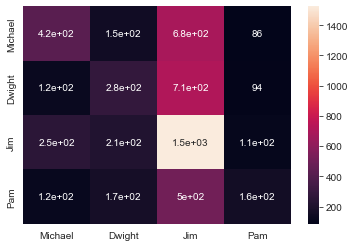

0.4267025089605735


In [141]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# using CountVectorizer vectors
model_lr_cv=LogisticRegression()
model_lr_cv.fit(X_train_cv, y_train)
score_cv = model_lr_cv.score(X_test_cv, y_test)

# predict y for test dataset
y_pred = model_lr_cv.predict(X_test_cv)
y_prob = model_lr_cv.predict_proba(X_test_cv)[:,1]
print(classification_report(y_test,y_pred))

cf_cv = confusion_matrix(y_test, y_pred)
print("confusion matrix:")
print(cf_cv)

sns.heatmap(cf_cv, annot=True, xticklabels=['Michael', 'Dwight', 'Jim', 'Pam'], yticklabels=['Michael', 'Dwight', 'Jim', 'Pam'])
plt.show()

print(score_cv)

              precision    recall  f1-score   support

      Dwight       0.45      0.33      0.38      1338
         Jim       0.34      0.26      0.29      1206
     Michael       0.44      0.68      0.54      2093
         Pam       0.34      0.17      0.23       943

    accuracy                           0.42      5580
   macro avg       0.39      0.36      0.36      5580
weighted avg       0.41      0.42      0.40      5580

confusion matrix:
[[ 440  160  643   95]
 [ 130  310  658  108]
 [ 292  258 1423  120]
 [ 111  191  476  165]]


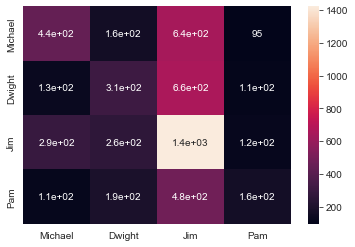

0.4189964157706093


In [142]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# using Tf-Idf vectors
model_lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
model_lr_tfidf.fit(X_train_tfidf, y_train)
score_tfidf = model_lr_tfidf.score(X_test_tfidf, y_test)

# predict y for test dataset
y_pred = model_lr_tfidf.predict(X_test_tfidf)
y_prob = model_lr_tfidf.predict_proba(X_test_tfidf)[:,1]
print(classification_report(y_test,y_pred))

cf = confusion_matrix(y_test, y_pred)
print("confusion matrix:")
print(cf)

sns.heatmap(cf, annot=True, xticklabels=['Michael', 'Dwight', 'Jim', 'Pam'], yticklabels=['Michael', 'Dwight', 'Jim', 'Pam'])
plt.show()
print(score_tfidf)

### Fitting Model using Naive Bayes

              precision    recall  f1-score   support

      Dwight       0.56      0.17      0.26      1338
         Jim       0.42      0.07      0.11      1206
     Michael       0.40      0.94      0.56      2093
         Pam       0.47      0.02      0.04       943

    accuracy                           0.41      5580
   macro avg       0.46      0.30      0.24      5580
weighted avg       0.45      0.41      0.30      5580

confusion matrix:
[[ 229   29 1069   11]
 [  50   79 1070    7]
 [  88   36 1964    5]
 [  42   42  839   20]]


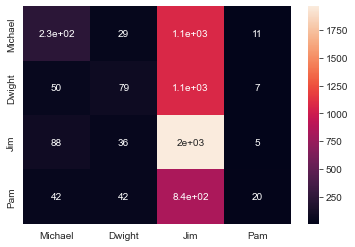

0.4189964157706093


In [143]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes using Tf-Idf vector
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_train)
score_nb = model_lr_tfidf.score(X_test_tfidf, y_test)

y_pred_nb = naive_bayes_classifier.predict(X_test_tfidf)

print(classification_report(y_test,y_pred_nb))

cf = confusion_matrix(y_test, y_pred_nb)
print("confusion matrix:")
print(cf)

sns.heatmap(cf, annot=True, xticklabels=['Michael', 'Dwight', 'Jim', 'Pam'], yticklabels=['Michael', 'Dwight', 'Jim', 'Pam'])

plt.show()
print(score_nb)

### LSTM
LSTM is effective in memorizing important information. It can use a multiple word string to find out the class to which it belongs. The first hyperparameter of LSTM() is units and defines the number of neurons that work as the memory unit of the model.

Before we can use the quotes in our sequential model, some changes of the data's shape must be done.


In [144]:
print(X_train_cv.shape[1])
print(X_test_cv.shape)

8356
(5580, 8356)


In [145]:
# turn class names into numerical data ad save the new representation in a df
character_to_int = {
    "Michael": 0,
    "Dwight": 1,
    "Jim": 2,
    "Pam": 3
}
int_to_character = ["Michael", "Dwight", "Jim", "Pam"]
df_for_lstm = df_merged.copy()
df_for_lstm['character'] = df_for_lstm['character'].replace(character_to_int).astype('int8')

df_for_lstm.head()

,quote,character,preprocessed
0,So you’ve come to the master for guidance? Is ...,0,come master guidanc say grasshopp
1,"All right. Well, let me show you how it’s done.",0,right well let show done
2,"If you think she’s cute now, you should have s...",0,think cute seen coupl year ago
3,Any messages?,0,messag
4,"Oh! Pam, this is from Corporate. How many time...",0,oh pam corpor mani time told special file cabi...


The df with numerical class values is used at converting the text into sequences, which will be filled up with zeros so the sequences have equal length. Then, another train test split is performed for the usage with the keras model.

In [146]:
from keras.utils import pad_sequences

# train test split
X, y = df_for_lstm['preprocessed'], df_for_lstm['character']

#preprocessed quotes to sequence
max_length = max([len(d.split()) for d in X])
tokenizer = tf.keras.preprocessing.text.Tokenizer()
X = tokenizer.texts_to_sequences(X)

#pad sequence with zeros
X = pad_sequences(X, maxlen=max_length)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(X_train_lstm.shape)
print(X_test_lstm.shape)


(22319, 86)
(5580, 86)


In [147]:
print(X_train_lstm.shape[1])

86


#### Embedding Layer
The Embedding Layer of Keras takes the previously calculated integers of teh sequences and maps them to a dense vector of the embedding.The following parameters are defined:

 - input_dim: the size of the vocabulary
 - output_dim: the size of the dense vector
 - input_length: the length of the sequence, in our case the max_length used while pad_sequences

### Dense Layer
The neuron of a dense layer in a model receives output from every neuron of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication. The keras dense layer can take a set of hyperparameters of which we used the following:
 - Units: defines the size of the output from the dense layer = dimensionality of the output vector
 - Activation: activation function used for the transformation of the input values of neurons -> introduces non-linearity into neral network (necessary for learning th relationship between input and output values)
The last Dense layer of the model must have the number of classes as unit parameter.

#### Balancing
To encounter the imbalance of the dataset, class_weights are used while fitting the model. Some of the sequential models are fitted without using the class_weights and in some cases the class_weight hyperparameter is set.

In [148]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_lstm),
                                        y = y_train_lstm
                                    )
class_weights = dict(zip(np.unique(y_train_lstm), class_weights))
class_weights

{0: 0.655746856269832,
 1: 1.0640255530129672,
 2: 1.1678003348681456,
 3: 1.473006863780359}

#### Sequential Model with Embedding Layer and LSTM

In [149]:
from keras.layers import Embedding, LSTM, Dropout, Dense, Flatten
from keras import Sequential, layers

In [156]:
embedding_dim = 64
input_dim = X_train_lstm.shape[1]  # Number of features
num_classes = 4

model_seq = Sequential()
model_seq.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_length))

model_seq.add(LSTM(64, activation='relu', return_sequences=True))
model_seq.add(Dropout(0.2))
model_seq.add(LSTM(64,activation='relu'))
model_seq.add(Dropout(0.2))

model_seq.add(Dense(64,activation='relu'))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(64,activation='relu'))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(32,activation='relu'))
model_seq.add(Dropout(0.2))
model_seq.add(Dense(num_classes,activation='softmax'))

In [157]:
model_seq.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [159]:
#old model with embedding_dim=output_dim=64, 10 epochs, two LSTM layers and multiple Dense layers combined with Dropout against overfitting
history = model_seq.fit(X_train_lstm, y_train_lstm,
                    epochs=10,
                    verbose="auto",
                    validation_data=(X_test_lstm, y_test_lstm),
                    batch_size=64)
loss1, accuracy1 = model_seq.evaluate(X_train_lstm, y_train_lstm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy1))

Epoch 1/10
349/349 [==============================] - 30s 85ms/step - loss: 1.3448 - accuracy: 0.3815 - val_loss: 1.3421 - val_accuracy: 0.3751
Epoch 2/10
349/349 [==============================] - 32s 92ms/step - loss: 1.3412 - accuracy: 0.3812 - val_loss: 1.3423 - val_accuracy: 0.3751
Epoch 3/10
349/349 [==============================] - 34s 98ms/step - loss: 1.3405 - accuracy: 0.3812 - val_loss: 1.3423 - val_accuracy: 0.3751
Epoch 4/10
349/349 [==============================] - 37s 105ms/step - loss: 1.3404 - accuracy: 0.3812 - val_loss: 1.3424 - val_accuracy: 0.3751
Epoch 5/10
349/349 [==============================] - 40s 115ms/step - loss: 1.3403 - accuracy: 0.3812 - val_loss: 1.3420 - val_accuracy: 0.3751
Epoch 6/10
349/349 [==============================] - 38s 109ms/step - loss: 1.3396 - accuracy: 0.3812 - val_loss: 1.3419 - val_accuracy: 0.3751
Epoch 7/10
349/349 [==============================] - 34s 97ms/step - loss: 1.3398 - accuracy: 0.3812 - val_loss: 1.3421 - val_accura

In [160]:
def plot_history(h):
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Loss')
    plt.legend()

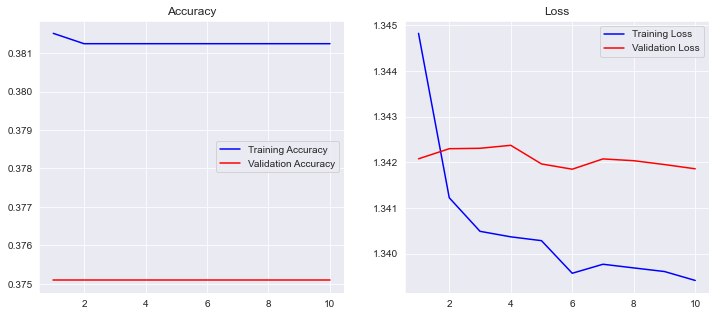

In [161]:
# plot accuracy and loss of model "model_seq"
plot_history(history)

Trying out more Dense layers and changing activation function of last Dense layer to sigmoid.

In [163]:
embedding_dim = 128
input_dim = X_train_lstm.shape[1]  # Number of features
num_classes = 4

model_seq2 = Sequential()
model_seq2.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_length))

model_seq2.add(LSTM(128, activation='relu', return_sequences=True))
model_seq2.add(Dropout(0.2))
model_seq2.add(LSTM(128,activation='relu'))
model_seq2.add(Dropout(0.2))

model_seq2.add(Dense(128,activation='relu'))
model_seq2.add(Dropout(0.2))
model_seq2.add(Dense(128,activation='relu'))
model_seq2.add(Dropout(0.2))
model_seq2.add(Dense(64,activation='relu'))
model_seq2.add(Dropout(0.2))
model_seq2.add(Dense(32,activation='relu'))
model_seq2.add(Dropout(0.2))
model_seq2.add(Dense(32,activation='relu'))
model_seq2.add(Dropout(0.2))

model_seq2.add(Dense(num_classes,activation='sigmoid'))

In [164]:
model_seq2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [165]:
history2 = model_seq2.fit(X_train_lstm, y_train_lstm,
                    epochs=10,
                    verbose="auto",
                    validation_data=(X_test_lstm, y_test_lstm),
                    batch_size=64)
loss2, accuracy2 = model_seq2.evaluate(X_train_lstm, y_train_lstm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy2))
print("Training Loss: {:.4f}".format(loss2))

Epoch 1/10
349/349 [==============================] - 111s 312ms/step - loss: 1.3453 - accuracy: 0.3810 - val_loss: 1.3426 - val_accuracy: 0.3751
Epoch 2/10
349/349 [==============================] - 108s 309ms/step - loss: 1.3414 - accuracy: 0.3812 - val_loss: 1.3420 - val_accuracy: 0.3751
Epoch 3/10
349/349 [==============================] - 103s 296ms/step - loss: 1.3405 - accuracy: 0.3812 - val_loss: 1.3418 - val_accuracy: 0.3751
Epoch 4/10
349/349 [==============================] - 91s 260ms/step - loss: 1.3396 - accuracy: 0.3812 - val_loss: 1.3421 - val_accuracy: 0.3751
Epoch 5/10
349/349 [==============================] - 76s 219ms/step - loss: 1.3396 - accuracy: 0.3812 - val_loss: 1.3420 - val_accuracy: 0.3751
Epoch 6/10
349/349 [==============================] - 76s 219ms/step - loss: 1.3400 - accuracy: 0.3812 - val_loss: 1.3418 - val_accuracy: 0.3751
Epoch 7/10
349/349 [==============================] - 78s 223ms/step - loss: 1.3393 - accuracy: 0.3812 - val_loss: 1.3419 - val

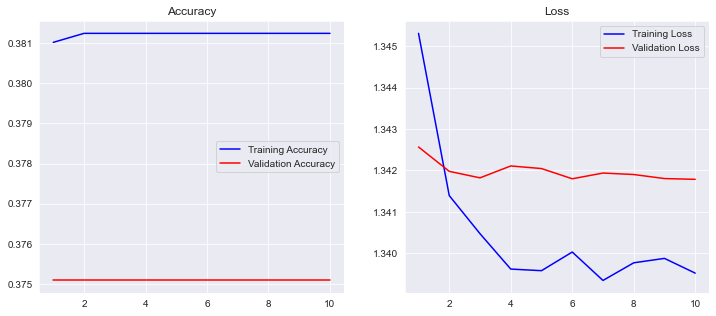

In [166]:
# plot accuracy and loss of model "model_seq2"
plot_history(history2)

#### fit model with balancing by class weights

In [167]:
# fit with class weights
history2_balanced = model_seq2.fit(X_train_lstm, y_train_lstm,
                    epochs=10,
                    verbose="auto",
                    validation_data=(X_test_lstm, y_test_lstm),
                    batch_size=64,
                    class_weight=class_weights)
loss2_bal, accuracy2_bal = model_seq2.evaluate(X_train_lstm, y_train_lstm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy2_bal))
print("Training Loss: {:.4f}".format(loss2_bal))

Epoch 1/10
349/349 [==============================] - 139s 394ms/step - loss: 1.3927 - accuracy: 0.3812 - val_loss: 1.3772 - val_accuracy: 0.3751
Epoch 2/10
349/349 [==============================] - 146s 419ms/step - loss: 1.3865 - accuracy: 0.3812 - val_loss: 1.3840 - val_accuracy: 0.3751
Epoch 3/10
349/349 [==============================] - 125s 357ms/step - loss: 1.3864 - accuracy: 0.3069 - val_loss: 1.3855 - val_accuracy: 0.3751
Epoch 4/10
349/349 [==============================] - 118s 338ms/step - loss: 1.3864 - accuracy: 0.2381 - val_loss: 1.3865 - val_accuracy: 0.2161
Epoch 5/10
349/349 [==============================] - 133s 381ms/step - loss: 1.3864 - accuracy: 0.2263 - val_loss: 1.3855 - val_accuracy: 0.3751
Epoch 6/10
349/349 [==============================] - 140s 402ms/step - loss: 1.3864 - accuracy: 0.2992 - val_loss: 1.3861 - val_accuracy: 0.3751
Epoch 7/10
349/349 [==============================] - 157s 450ms/step - loss: 1.3864 - accuracy: 0.2213 - val_loss: 1.3860 -

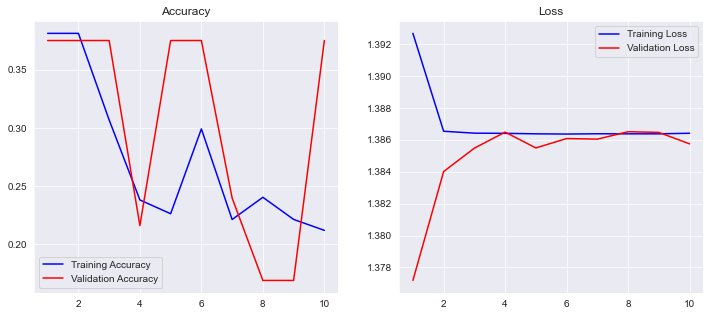

In [168]:
# plot accuracy and loss of model "model_seq2" with class weights for balancing
plot_history(history2_balanced)

#### Basic LSTM with only one Dense layer (balanced)
The accuracy of the model does not change when tuning the hyperparameters, so a simple model and few little number of epochs are sufficient.

In [169]:
embedding_dim = 32
input_dim = X_train_lstm.shape[1]  # Number of features
num_classes = 4

model_seq3 = Sequential()
model_seq3.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=max_length))

# LSTM layer has 100 neurons which will work as the memory unit of the model
model_seq3.add(LSTM(100))
model_seq3.add(Dense(num_classes,activation='sigmoid'))

In [170]:
model_seq3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [171]:
history3 = model_seq3.fit(X_train_lstm, y_train_lstm,
                    epochs=10,
                    verbose="auto",
                    validation_data=(X_test_lstm, y_test_lstm),
                    batch_size=32,
                    class_weight=class_weights)
loss3, accuracy3 = model_seq3.evaluate(X_train_lstm, y_train_lstm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy3))
print("Training Loss: {:.4f}".format(loss3))

Epoch 1/10
698/698 [==============================] - 71s 100ms/step - loss: 1.3869 - accuracy: 0.2496 - val_loss: 1.3890 - val_accuracy: 0.2161
Epoch 2/10
698/698 [==============================] - 73s 105ms/step - loss: 1.3866 - accuracy: 0.2238 - val_loss: 1.3863 - val_accuracy: 0.2161
Epoch 3/10
698/698 [==============================] - 75s 107ms/step - loss: 1.3866 - accuracy: 0.2066 - val_loss: 1.3857 - val_accuracy: 0.2161
Epoch 4/10
698/698 [==============================] - 74s 106ms/step - loss: 1.3865 - accuracy: 0.2665 - val_loss: 1.3879 - val_accuracy: 0.1690
Epoch 5/10
698/698 [==============================] - 74s 106ms/step - loss: 1.3865 - accuracy: 0.2359 - val_loss: 1.3873 - val_accuracy: 0.2161
Epoch 6/10
698/698 [==============================] - 73s 104ms/step - loss: 1.3865 - accuracy: 0.2329 - val_loss: 1.3871 - val_accuracy: 0.1690
Epoch 7/10
698/698 [==============================] - 64s 91ms/step - loss: 1.3865 - accuracy: 0.2045 - val_loss: 1.3858 - val_acc

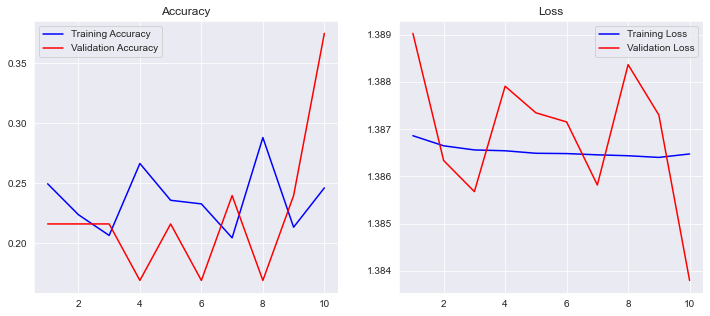

In [172]:
plot_history(history3)

### Evaluate the Model

In [173]:
y_pred_lstm = model_seq3.predict(X_test_lstm, verbose=1)
y_pred_lstm = y_pred_lstm.argmax(axis=1)

175/175 [==============================] - 4s 19ms/step


confusion matrix:
[[2093    0    0    0]
 [1338    0    0    0]
 [1206    0    0    0]
 [ 943    0    0    0]]


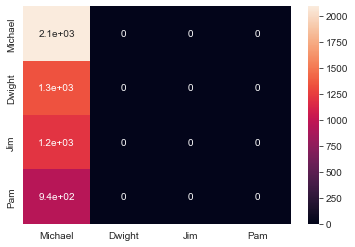

0.3812446892261505


In [174]:
cf_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
print("confusion matrix:")
print(cf_lstm)

sns.heatmap(cf_lstm, annot=True, xticklabels=['Michael', 'Dwight', 'Jim', 'Pam'], yticklabels=['Michael', 'Dwight', 'Jim', 'Pam'])

plt.show()
print(accuracy3)

### Comparing the models
When the model fit is performed without class weights, the accuracy of the sequential models is equal or at least very similar. This results from the imbalance of the dataset. The other Classifiers (Linear Regression, Naive Bayes) provide a slightly better accuracy than the keras model.

In [181]:
df_compare = pd.DataFrame(columns=['model','class_weights(balanced)', 'accuracy', 'loss'])

df_compare['model'] = ["model_lr_cv", "model_lr_tfidf", "naive_bayes_classifier", "model_seq", "model_seq2","model_seq2" , "model_seq3"]
df_compare['class_weights(balanced)'] = ["no", "no", "no", "no", "no","yes" , "yes"]
df_compare['accuracy'] = [score_cv, score_tfidf, score_nb, accuracy1, accuracy2, accuracy2_bal, accuracy3]
df_compare['loss'] = ["-", "-", "-", loss1, loss2, loss2_bal, loss3]
df_compare

,model,class_weights(balanced),accuracy,loss
0,model_lr_cv,no,0.426703,-
1,model_lr_tfidf,no,0.418996,-
2,naive_bayes_classifier,no,0.418996,-
3,model_seq,no,0.381245,1.338954
4,model_seq2,no,0.381245,1.339008
5,model_seq2,yes,0.381245,1.385696
6,model_seq3,yes,0.381245,1.383732


## LDA

Extract the main topics of the data or rather of each character's quotes by using LDA(Latent Dirichlet Allocation).
LDA classifies the text of the dataset to a particular topic. Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.

We start by building a dictionary out of the preprocessed quotes in the dataframe "df_for_lda" that we saved after tokenization and lemmatization.

In [55]:
df_for_lda.head()

,quote,character,stemmed
0,So you’ve come to the master for guidance? Is ...,Michael,"[come, master, guidanc, say, grasshopp]"
1,"All right. Well, let me show you how it’s done.",Michael,"[right, well, let, show, done]"
2,"If you think she’s cute now, you should have s...",Michael,"[think, cute, seen, coupl, year, ago]"
3,Any messages?,Michael,[messag]
4,"Oh! Pam, this is from Corporate. How many time...",Michael,"[oh, pam, corpor, mani, time, told, special, f..."


In [56]:
dictionary = gensim.corpora.Dictionary(df_for_lda['stemmed'])

We use the created dictionary for each document to convert it into a bag of words. The dictionary reports how many words and how many times those words appear in the document.

In [57]:
bow_corpus = [dictionary.doc2bow(doc) for doc in df_for_lda['stemmed']]

In [58]:
lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 8,
                                   id2word = dictionary,
                                   passes = 10,
                                   workers = 2)

In [310]:
import os
import pickle
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Visualize the topics
num_topics = 8
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))


if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Users\angel\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.119096  0.040191       1        1  16.581110
5     -0.107185  0.046632       2        1  15.103053
3     -0.089848  0.007229       3        1  13.379880
2     -0.104778  0.077395       4        1  12.998412
7     -0.098028  0.003304       5        1  12.202583
0      0.043337 -0.267107       6        1  10.372391
6      0.211103 -0.112669       7        1  10.074913
4      0.264495  0.205025       8        1   9.287659, topic_info=        Term         Freq        Total Category  logprob  loglift
21        oh  1672.000000  1672.000000  Default  30.0000  30.0000
54      yeah  1164.000000  1164.000000  Default  29.0000  29.0000
436     okay  1116.000000  1116.000000  Default  28.0000  28.0000
59      good  1024.000000  1024.000000  Default  27.0000  27.0000
7      right  1138.000000  1138.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
251  michael    92.072694   954.419529   Topic8  -4.9493   0.0380
51     great    73.451318   548.256466   Topic8  -5.1752   0.3664
115      man    61.651908   375.687309   Topic8  -5.3504   0.5692
128     take    63.167210   513.082255   Topic8  -5.3261   0.2818
623     name    53.891879   190.623622   Topic8  -5.4849   1.1132

[569 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1128      1  0.129544        abl
1128      2  0.018506        abl
1128      4  0.832783        abl
1191      4  0.846680        act
1191      6  0.148169        act
...     ...       ...        ...
1322      7  0.995432        yep
2327      3  0.992325  yesterday
2193      6  0.996209       york
1040      3  0.992518        yup
3710      3  0.955142       zero

[1209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 3, 8, 1, 7, 5])